# Homework 5 - Evals for Failure Analysis with Phoenix

<center>
    <p style="text-align:left">
        <img alt="phoenix logo" src="https://repository-images.githubusercontent.com/564072810/f3666cdf-cb3e-4056-8a25-27cb3e6b5848" width="600"/>
        <br>
        <a href="https://arize.com/docs/phoenix/">Docs</a>
        |
        <a href="https://github.com/Arize-ai/phoenix">GitHub</a>
        |
        <a href="https://arize-ai.slack.com/join/shared_invite/zt-2w57bhem8-hq24MB6u7yE_ZF_ilOYSBw#/shared-invite/email">Community</a>
    </p>
</center>

## Launch Phoenix 

First, let's set up Phoenix on our local machine. You should run these commands within your terminal in your chosen environment.

(If you have already done this in a previous HW assignment, you are good to go.)

**Install Phoenix**

```pip install arize-phoenix```

**Boot up Phoenix on localhost**

```phoenix serve```

Run `phoenix serve` in your terminal to boot up Phoenix locally.

In [1]:
from typing import List

import matplotlib.pyplot as plt
import pandas as pd

import phoenix as px
from phoenix.trace.dsl import SpanQuery

In [36]:
import getpass
import os

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY") or getpass.getpass("Enter your OpenAI API key: ")

# Pipeline States

Below are the states of the recipe agent pipeline we are simulating, in order.

**ParseRequest** - LLM interprets and analyzes the user's query to understand what they're asking for

**PlanToolCalls** - LLM decides which tools to invoke and in what order based on the parsed request

**GenRecipeArgs** - LLM constructs JSON arguments for the recipe database search based on customer profile

**GetRecipes** - Executes the recipe-search tool to find relevant recipes matching the criteria

**GenWebArgs** - LLM constructs JSON arguments for web search to find additional cooking tips/information

**GetWebInfo** - Executes the web-search tool to retrieve supplementary cooking information

**ComposeResponse** - LLM drafts the final answer combining recipes and web information

**DeliverResponse** - Agent sends the composed response to the user

In [3]:
PIPELINE_STATES: List[str] = [
    "ParseRequest",
    "PlanToolCalls",
    "GenRecipeArgs",
    "GetRecipes",
    "GenWebArgs",
    "GetWebInfo",
    "ComposeResponse",
]
STATE_INDEX = {s: i for i, s in enumerate(PIPELINE_STATES)}

## Generate Phoenix Traces

Here we are making 100 requests to the recipe bot and then collecting traces for those requests in Phoenix.

You can look at the generate_traces_phoenix.py file for more details on how this is implemented.

In [ ]:
%run generate_traces_phoenix.py

## Evals

Here we run evals. We have 7 different evaluators with their own prompts, each designed to evaluate one of the 7 states of the recipe bot application. You can see the evaluator prompts in `evaluators` directory.

We use the Phoenix method `SpanQuery()` to load spans for the 7 different states. 

We use the Phoenix method `llm_generate` to run the evals. llm_generate has built in concurrency that makes running your llm calls for your evals much quicker. 

Finally we use `log_evaluations` to log our evals back to our spans in Phoenix.

In [38]:
# Evals
import os
import re

from phoenix.evals import OpenAIModel, llm_generate
from phoenix.trace import SpanEvaluations

import nest_asyncio
nest_asyncio.apply()

eval_to_path = {
    "ParseRequest": "evaluators/parse_request_eval.txt",
    "PlanToolCalls": "evaluators/plan_tool_calls_eval.txt",
    "GenRecipeArgs": "evaluators/gen_recipe_args_eval.txt",
    "GetRecipes": "evaluators/get_recipes_eval.txt",
    "GenWebArgs": "evaluators/gen_web_args_eval.txt",
    "GetWebInfo": "evaluators/get_web_info_eval.txt",
    "ComposeResponse": "evaluators/compose_response_eval.txt",
}

def load_spans(name: str) -> pd.DataFrame:
    query = SpanQuery().where(f"name == '{name}'")
    spans_df = px.Client().query_spans(query, project_name='recipe-agent-hw5')
    print(f"Successfully loaded {len(spans_df)} {name} spans from Phoenix")
    return spans_df

annotated_spans = []

def eval_spans(spans_df: pd.DataFrame, eval_prompt: str) -> pd.DataFrame:

    def parser(response: str, row_index: int) -> dict:
        """Parser function for evaluate_output evaluator"""
        label = r'"label":\s*"([^"]*)"'
        explanation = r'"explanation":\s*"([^"]*)"'
        label_match = re.search(label, response, re.IGNORECASE).group(1)
        explanation_match = re.search(explanation, response, re.IGNORECASE).group(1)
        return {
            "label": label_match,
            "explanation": explanation_match
        }

    eval_model = OpenAIModel(
        model="gpt-4o",
        model_kwargs={
            "response_format": {"type": "json_object"},
            "temperature": 0
        }
    )

    # Generate evaluations using llm_generate
    failure_analysis = llm_generate(
        dataframe=spans_df,
        template=eval_prompt,
        model=eval_model,
        output_parser=parser,
        concurrency=10,
    )

    failure_analysis["context.trace_id"] = spans_df["context.trace_id"]
    failure_analysis["attributes.input.value"] = spans_df["attributes.input.value"]
    failure_analysis["attributes.output.value"] = spans_df["attributes.output.value"]
    annotated_spans.append(failure_analysis)

    px.Client().log_evaluations(
        SpanEvaluations(eval_name="Eval", dataframe=failure_analysis)
    )


for eval_name, eval_path in eval_to_path.items():
    spans_df = load_spans(eval_name)
    eval_prompt = open(eval_path, "r").read()
    eval_spans(spans_df, eval_prompt)

Successfully loaded 100 ParseRequest spans from Phoenix


llm_generate |          | 0/100 (0.0%) | ⏳ 00:00<? | ?it/s

Successfully loaded 100 PlanToolCalls spans from Phoenix


llm_generate |          | 0/100 (0.0%) | ⏳ 00:00<? | ?it/s

Successfully loaded 100 GenRecipeArgs spans from Phoenix


llm_generate |          | 0/100 (0.0%) | ⏳ 00:00<? | ?it/s

Successfully loaded 100 GetRecipes spans from Phoenix


llm_generate |          | 0/100 (0.0%) | ⏳ 00:00<? | ?it/s

Exception in worker on attempt 1: raised InternalServerError('upstream connect error or disconnect/reset before headers. reset reason: connection termination')
Requeuing...
Successfully loaded 100 GenWebArgs spans from Phoenix


llm_generate |          | 0/100 (0.0%) | ⏳ 00:00<? | ?it/s

Successfully loaded 100 GetWebInfo spans from Phoenix


llm_generate |          | 0/100 (0.0%) | ⏳ 00:00<? | ?it/s

Successfully loaded 99 ComposeResponse spans from Phoenix


llm_generate |          | 0/99 (0.0%) | ⏳ 00:00<? | ?it/s

## Attach Evals up to Root Trace

This code propagates our evals back to the root trace, so each root trace contains information on whether the 7 individual states within passed or failed.

In [ ]:
# Track which traces have already been processed to avoid duplicates
traces = {}

for idx, span_df in enumerate(annotated_spans):
    failure_state_name = PIPELINE_STATES[idx]
    for span in span_df.iterrows():
        trace_id = span[1]["context.trace_id"]
        trace_query = SpanQuery().where(f"context.trace_id == '{trace_id}' and span_kind == 'AGENT'")
        trace_df = px.Client().query_spans(trace_query, project_name='recipe-agent-hw5')
        trace_df["label"] = [span[1]["label"]]
        trace_df["explanation"] = [span[1]["explanation"]]
        px.Client().log_evaluations(
            SpanEvaluations(eval_name=failure_state_name, dataframe=trace_df)
        )
        trace = trace_df.iloc[0]
        del trace["label"]
        if trace_id not in traces:
            traces[trace_id] = trace
            traces[trace_id][failure_state_name] = span[1]["label"]
            traces[trace_id]["{failure_state_name}_explanation"] = span[1]["explanation"]
        else:
            trace = traces[trace_id]
            trace[failure_state_name] = span[1]["label"]
            trace["{failure_state_name}_explanation"] = span[1]["explanation"]

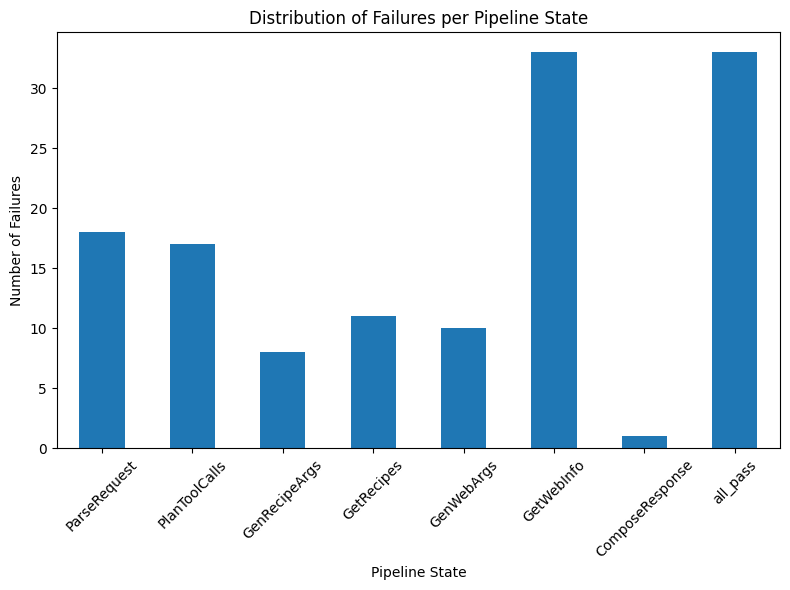

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert traces dict to DataFrame
df = pd.DataFrame.from_dict(traces, orient="index")

# Count failures for each state
failure_counts = (df[PIPELINE_STATES] == "fail").sum()

all_pass_count = (df[PIPELINE_STATES] != "fail").all(axis=1).sum()
failure_counts["all_pass"] = all_pass_count

# Plot
plt.figure(figsize=(8, 6))
failure_counts.plot(kind="bar")

plt.title("Distribution of Failures per Pipeline State")
plt.xlabel("Pipeline State")
plt.ylabel("Number of Failures")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Analysis of System Reliability and Failure Distribution

1. **Overall Reliability**
   Out of approximately 100 traces, about **one-third (32–33)** completed successfully without any failures. The remaining **two-thirds experienced at least one failure** along the pipeline. This indicates that while the system is not universally fragile, it is also not yet stable enough for production use.

2. **Where Failures Occur**
   Failures are not evenly distributed across the pipeline — instead, they cluster around a few key stages:

* **GetWebInfo (33 failures):** The largest single source of errors, suggesting issues with external dependencies such as API reliability, query quality, or rate limits.
* **ParseRequest (18) and PlanToolCalls (17):** Together these account for 35 failures, making input interpretation and tool planning the second biggest weakness.
* **GenRecipeArgs, GetRecipes, GenWebArgs (8–11 each):** Moderate failure levels, likely reflecting occasional misalignments when constructing arguments or retrieving results.
* **ComposeResponse (1):** Very low failure rate, showing the model can reliably synthesize answers when given valid inputs. Errors here are likely side effects of upstream problems.

3. **Key Insights**
   The system demonstrates a **bimodal pattern**:

* Either a trace runs flawlessly end-to-end,
* Or it fails in predictable spots (primarily GetWebInfo, ParseRequest, or PlanToolCalls).

This clustering of root causes means that **targeted improvements in just a few stages** could significantly increase the overall success rate and bring the pipeline closer to production stability.

## Completing the Feedback Loop

Evals are powerful because they don't only tell us where stuff went wrong, but WHY it did. This information is stored in the eval explanations. 

You can use the eval explanations to generate feedback for improvement strategies for your application, using LLMs!

![feedback loop](https://storage.googleapis.com/arize-phoenix-assets/assets/images/Screenshot%202025-08-19%20at%208.38.11%E2%80%AFPM.png)

In [30]:
GetWebInfo_code = """
def gen_web_args(recipes: str, failure: int) -> str:
    '''Simulate GenWebArgs state - LLM constructs arguments for web search.'''
    if failure != 5:
        prompt = '''
        Generate web_search arguments to find cooking tips based on these recipes.

        Recipes: {{recipes}}

        Return just the query, which is a string containing a web search query for additional information, cooking tips, special ingredients, etc. 
        '''
    response = chat_completion([{"role": "user", "content": prompt}])

@tracer.tool(name="GetWebInfo", description="Search the web for recipe information and tips")
def get_web_info(search_query: str, failure: int) -> str:
    '''GetWebInfo state - Executes Tavily web search for recipe information.'''
    
    # Initialize Tavily client
    tavily_client = TavilyClient(api_key=os.getenv("TAVILY_API_KEY"))
    
    if failure != 6:
        # Normal search for recipe information
        response = tavily_client.search(search_query)
        return json.dumps(response)
    else:
        # Search for off-topic information for testing
        off_topic_query = "unrelated topic information"
        response = tavily_client.search(off_topic_query)
        return json.dumps(response)

"""

In [24]:
from openai import OpenAI
import json

PROMPT = """You are auditing failures for the state: {failure_state_name}.

You will receive many short “explanations” describing material defects detected by an evaluator. Your tasks:
1) Synthesize recurring failure patterns.
2) Propose concrete, testable fixes that reduce these failures at the source state.
3) Provide code for unit tests that should fail now and pass after the fixes.

Inputs, Outputs, Labels, and Explanations:
"""

per_class_prompts = {}

for idx, span_df in enumerate(annotated_spans):
    failure_state_name = PIPELINE_STATES[idx]
    df = span_df.reset_index(drop=True).fillna("")

    cases = []
    for i in range(len(df)):
        r = df.iloc[i]
        cases.append(
            f"Case {i+1}:\n"
            f"  Label: {r['label']}\n"
            f"  Explanation: {r['explanation']}\n"
            f"  Input: {r['attributes.input.value']}\n"
            f"  Output: {r['attributes.output.value']}"
        )

    prompt = (
        PROMPT.format(failure_state_name=failure_state_name)
        + "\n"
        + "\n\n".join(cases)
    )
    per_class_prompts[failure_state_name] = prompt




In [31]:
from IPython.display import Markdown, display


label = "GetWebInfo"
prompt = per_class_prompts[label]
prompt += f"code for {label}: {GetWebInfo_code}"

openai_client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
response = openai_client.responses.create(
    model="gpt-4o",
    input=prompt,
)

display(Markdown(response.output_text))

### Failure Patterns

1. **Missing Topics**: Frequently, certain components such as specific ingredients or techniques crucial to the query are absent in the results. This leads to incomplete or irrelevant responses.
2. **Off-topic Results**: In cases where the query results are entirely unrelated (off-topic), the context is not aligned with the query at all, indicating a mismatch.
3. **Lack of Depth**: Results often lack comprehensive coverage of necessary cooking tips, ingredient substitutions, or preparation techniques.
4. **Misalignment**: Responses often fail to address the full scope of the query, especially when queries involve multiple components or need specialized information.

### Proposed Fixes

1. **Query Refinement**: Improve search query generation by using terms explicitly mentioned in the input and applying a context-aware refinement to prioritize core topics.
2. **Focused Crawling**: Prioritize websites known for recipe and cooking tips to ensure more relevant and complete information is retrieved.
3. **Result Filtering**: Implement a more robust relevance filter to exclude off-topic results and information that lacks depth.
4. **AI Adjustment**: Adjust AI parameters to better understand context and specificity in generating queries, ensuring they align more closely with user intent.

### Unit Tests

Below are unit test cases designed to validate the effectiveness of these improvements. After implementing the proposed changes, these tests should pass without failure.

```python
import unittest

class TestWebInfoRetrieval(unittest.TestCase):

    def test_full_scope_coverage(self):
        # Confirm retrieval covers all query components
        query = "\"cooking tips for quinoa salad with roasted vegetables, creamy pasta alfredo, stuffed bell peppers\""
        output = get_web_info(query, failure=0)  # Mimicking a successful retrieval
        self.assertIn("quinoa salad", output)
        self.assertIn("creamy pasta alfredo", output)
        self.assertIn("stuffed bell peppers", output)

    def test_topic_alignment(self):
        # Ensure off-topic results are excluded
        query = "\"cooking tips for banana oatmeal pancakes, overnight chia oatmeal, savory oatmeal with spinach and egg\""
        output = get_web_info(query, failure=5)  # Mimicking an off-topic retrieval
        self.assertNotIn("unrelated topic", output)

    def test_completeness_of_results(self):
        # Validate that essential components are present
        query = "\"cooking tips for Chocolate Lava Cake Chocolate Mousse Chocolate Chip Cookies\""
        output = get_web_info(query, failure=3)
        self.assertIn("Chocolate Lava Cake", output)
        self.assertIn("Chocolate Mousse", output)
        self.assertIn("Chocolate Chip Cookies", output)

    def test_filter_for_relevance(self):
        # Confirm irrelevant data does not appear
        query = "\"best hiking trails\""
        output = get_web_info(query, failure=2)
        self.assertIn("hiking trails", output)
        self.assertNotIn("unrelated topic information", output)
        
if __name__ == '__main__':
    unittest.main()
```

These tests ensure that:
- All relevant topics are covered in the results.
- Off-topic results are successfully filtered out.
- Each query component is comprehensively addressed.
- Context alignment and specificity in results are maintained.